In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/anat_mask.nc
Loading ../data/NAFLD/0006/mre_mask.nc
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


<IPython.core.display.Javascript object>


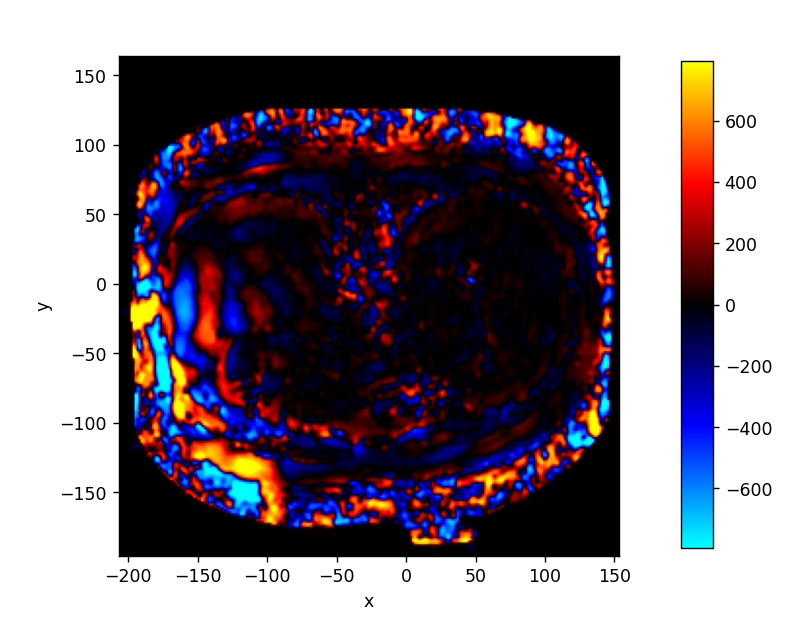

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids=['0006'], xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
#cohort.eval_baseline()
cohort[0].view(['wave'])

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data



<IPython.core.display.Javascript object>


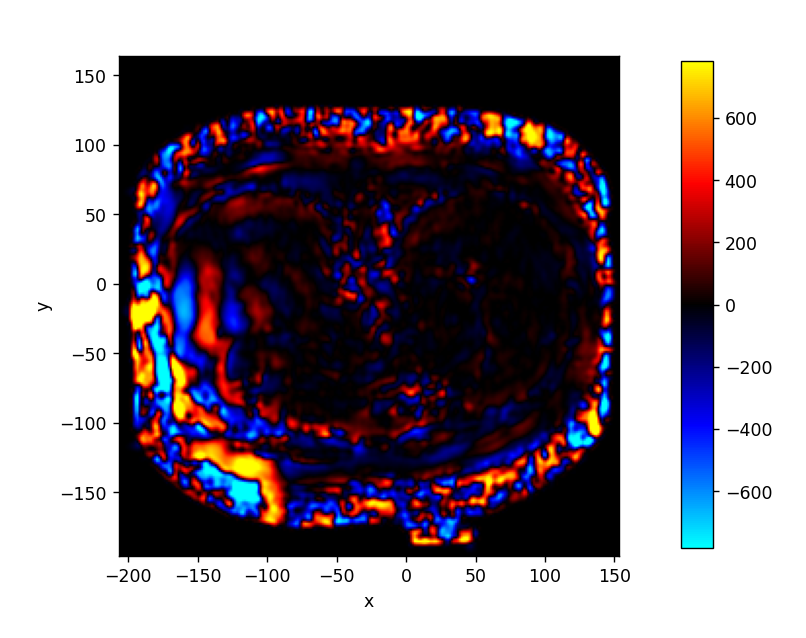

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


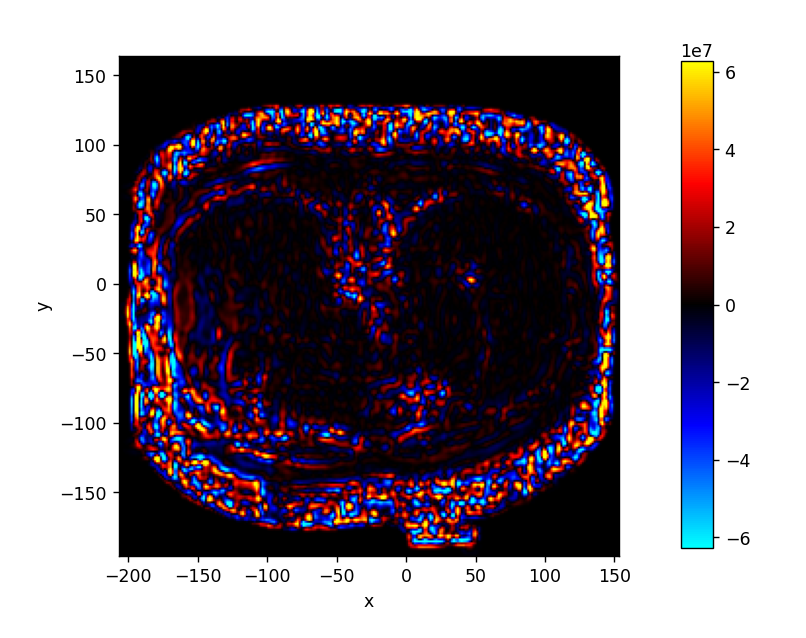

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


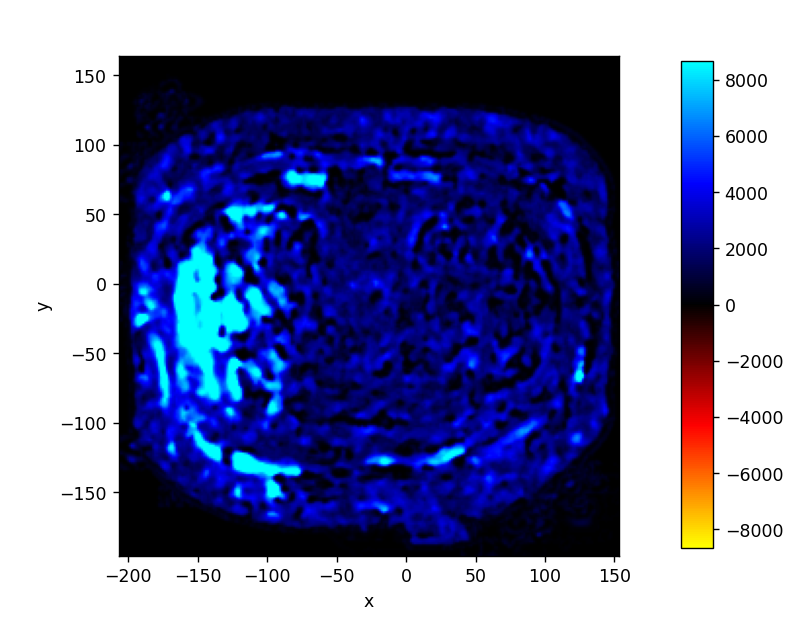

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


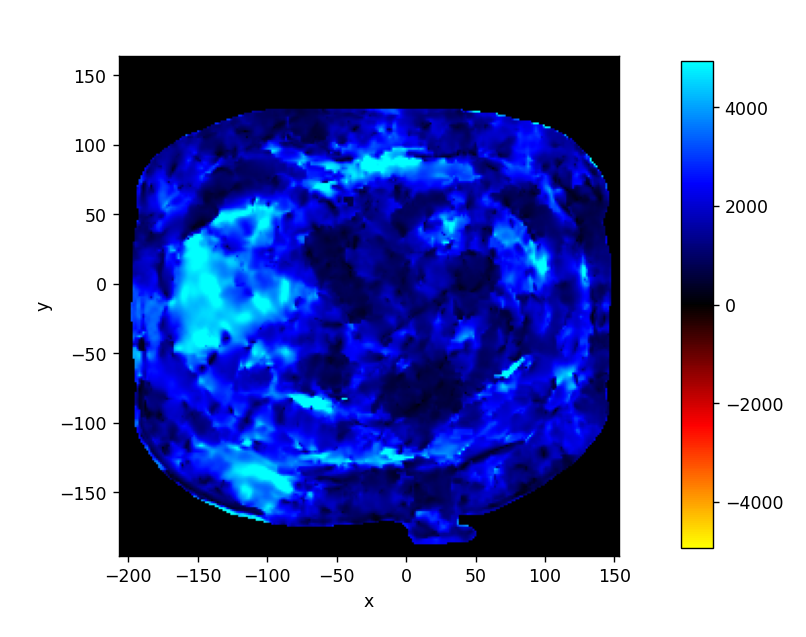

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [4]:
%autoreload
cohort[0].eval_baseline(order=3, kernel_size=5)
cohort[0].view(['Kwave', 'Lwave', 'Mwave', 'mre'])

In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', rho=1e6, detach=True)
pde

In [36]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_pinn_layers=4,
    n_pinn_hidden=16,
    u_omega=16,
    u_scale=1e2,
    u_loc=0,
    mu_omega=16,
    mu_scale=1,
    mu_loc=0,
    skip_connect=True,
    dense=True,
    debug=True
)
pino

input		 1 [256 256   4]
conv_in		 16 [256 256   4]
conv_block0	 16 [256 256   4]
pool0		 16 [128 128   2]
conv_block1	 32 [128 128   2]
pool1		 32 [64 64  1]
conv_block2	 64 [64 64  1]
pool2		 64 [32 32  1]
conv_block3	 128 [32 32  1]
pool3		 128 [16 16  1]
conv_block4	 256 [16 16  1]
pool4		 256 [8 8 1]
linear_out	 128
input		 1 [256 256   4]
conv_in		 16 [256 256   4]
conv_block0	 16 [256 256   4]
pool0		 16 [128 128   2]
conv_block1	 32 [128 128   2]
pool1		 32 [64 64  1]
conv_block2	 64 [64 64  1]
pool2		 64 [32 32  1]
conv_block3	 128 [32 32  1]
pool3		 128 [16 16  1]
conv_block4	 256 [16 16  1]
pool4		 256 [8 8 1]
linear_out	 128


HyperCNN(
  (u_cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1,

In [37]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss_weights=[1e-2, 0, 1e-12],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)

Compiling model...
'compile' took 0.000371 s



Training model...

0         [1.64e+02, 0.00e+00, 1.59e+04]    [1.64e+02, 0.00e+00, 1.59e+04]    []  


<IPython.core.display.Javascript object>


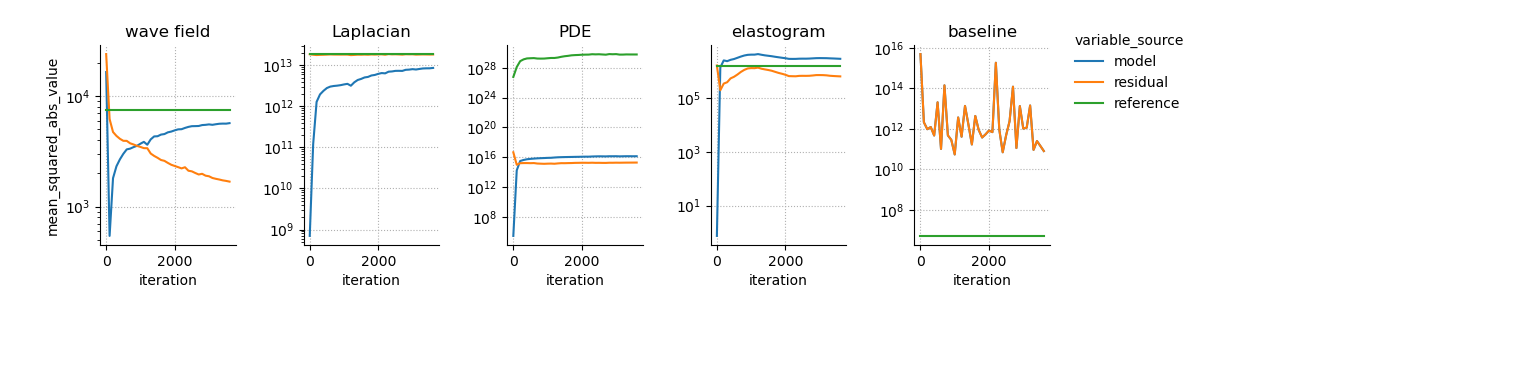

<IPython.core.display.Javascript object>


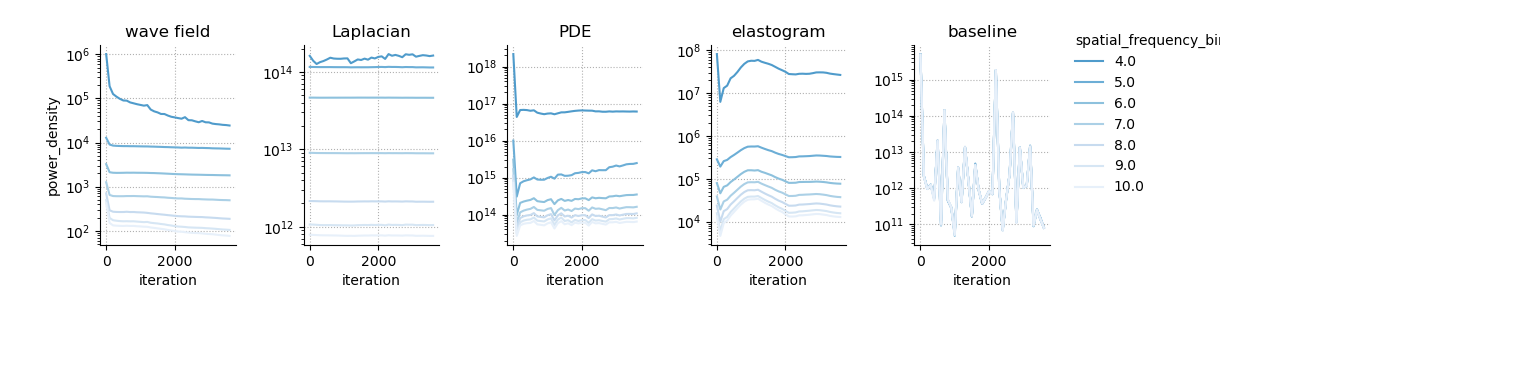

<IPython.core.display.Javascript object>


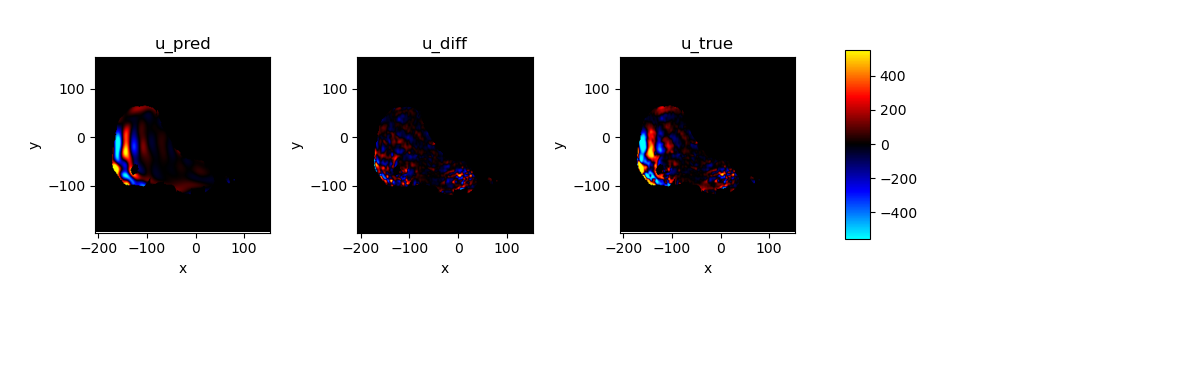

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


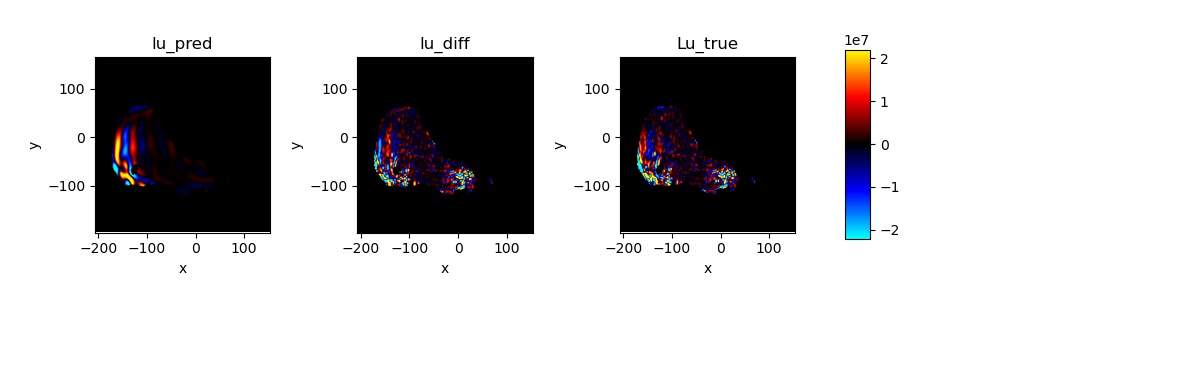

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


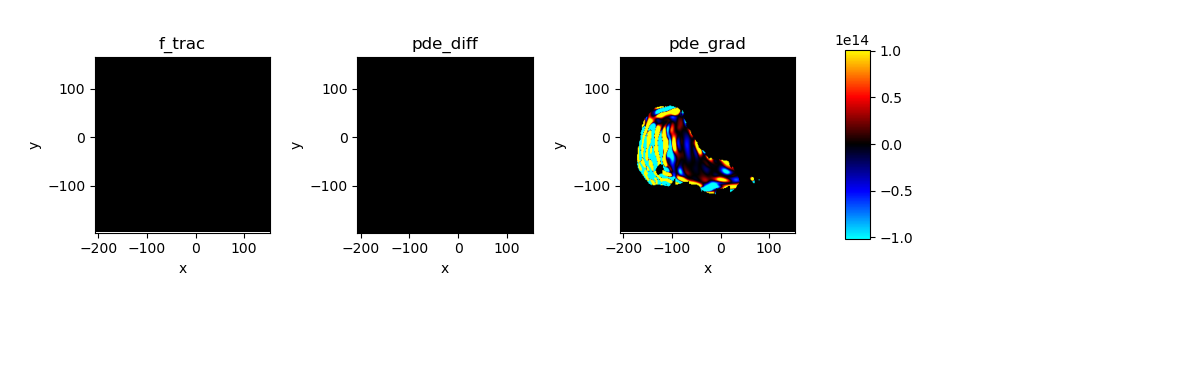

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


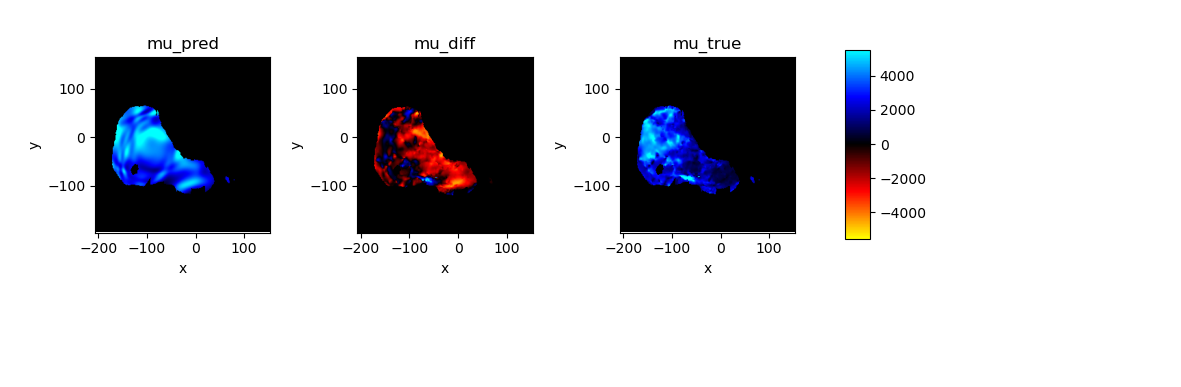

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


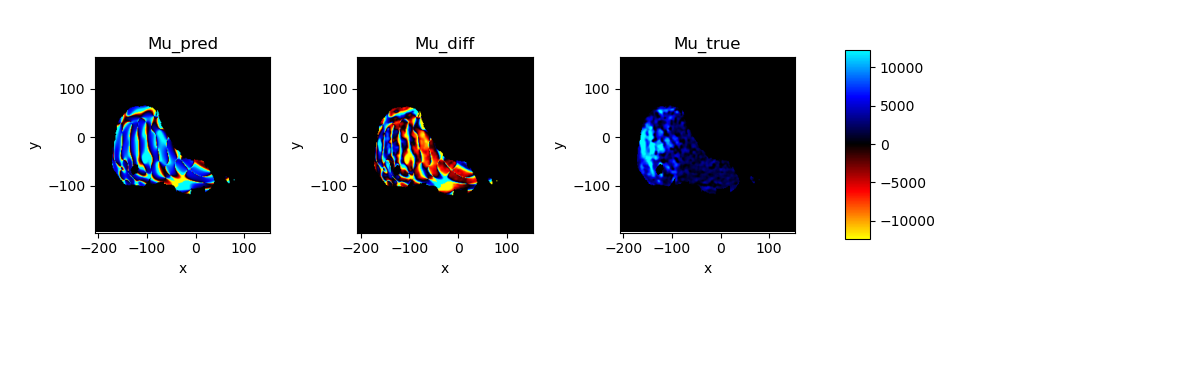

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

10        [7.80e+01, 0.00e+00, 8.09e+02]    [7.80e+01, 0.00e+00, 8.09e+02]    []  
20        [7.51e+01, 0.00e+00, 1.90e+02]    [7.51e+01, 0.00e+00, 1.90e+02]    []  
30        [7.40e+01, 0.00e+00, 2.50e+02]    [7.40e+01, 0.00e+00, 2.50e+02]    []  
40        [7.33e+01, 0.00e+00, 2.30e+02]    [7.33e+01, 0.00e+00, 2.30e+02]    []  
50        [7.26e+01, 0.00e+00, 1.76e+02]    [7.26e+01, 0.00e+00, 1.76e+02]    []  
60        [7.18e+01, 0.00e+00, 1.98e+02]    [7.18e+01, 0.00e+00, 1.98e+02]    []  
70        [7.05e+01, 0.00e+00, 2.27e+02]    [7.05e+01, 0.00e+00, 2.27e+02]    []  
80        [6.87e+01, 0.00e+00, 2.62e+02]    [6.87e+01, 0.00e+00, 2.62e+02]    []  
90        [6.57e+01, 0.00e+00, 3.03e+02]    [6.57e+01, 0.00e+00, 3.03e+02]    []  
Time spent testing: 46.07%
100       [6.19e+01, 0.00e+00, 3.39e+02]    [6.19e+01, 0.00e+00, 3.39e+02]    []  
110       [5.81e+01, 0.00e+00, 3.04e+02]    [5.81e+01, 0.00e+00, 3.04e+02]    []  
120       [5.60e+01, 0.00e+00, 4.04e+02]    [5.60e+01, 0.00e

970       [3.45e+01, 0.00e+00, 4.41e+02]    [3.45e+01, 0.00e+00, 4.41e+02]    []  
980       [3.44e+01, 0.00e+00, 4.36e+02]    [3.44e+01, 0.00e+00, 4.36e+02]    []  
990       [3.66e+01, 0.00e+00, 4.16e+02]    [3.66e+01, 0.00e+00, 4.16e+02]    []  
Time spent testing: 45.35%
1000      [3.46e+01, 0.00e+00, 4.77e+02]    [3.46e+01, 0.00e+00, 4.77e+02]    []  
1010      [3.44e+01, 0.00e+00, 4.69e+02]    [3.44e+01, 0.00e+00, 4.69e+02]    []  
1020      [3.39e+01, 0.00e+00, 4.46e+02]    [3.39e+01, 0.00e+00, 4.46e+02]    []  
1030      [3.38e+01, 0.00e+00, 4.34e+02]    [3.38e+01, 0.00e+00, 4.34e+02]    []  
1040      [3.37e+01, 0.00e+00, 4.47e+02]    [3.37e+01, 0.00e+00, 4.47e+02]    []  
1050      [3.35e+01, 0.00e+00, 4.39e+02]    [3.35e+01, 0.00e+00, 4.39e+02]    []  
1060      [3.34e+01, 0.00e+00, 4.43e+02]    [3.34e+01, 0.00e+00, 4.43e+02]    []  
1070      [3.33e+01, 0.00e+00, 4.43e+02]    [3.33e+01, 0.00e+00, 4.43e+02]    []  
1080      [3.36e+01, 0.00e+00, 4.27e+02]    [3.36e+01, 0.00e

1930      [2.38e+01, 0.00e+00, 6.36e+02]    [2.38e+01, 0.00e+00, 6.36e+02]    []  
1940      [2.37e+01, 0.00e+00, 6.34e+02]    [2.37e+01, 0.00e+00, 6.34e+02]    []  
1950      [2.35e+01, 0.00e+00, 6.29e+02]    [2.35e+01, 0.00e+00, 6.29e+02]    []  
1960      [2.33e+01, 0.00e+00, 6.23e+02]    [2.33e+01, 0.00e+00, 6.23e+02]    []  
1970      [2.33e+01, 0.00e+00, 6.23e+02]    [2.33e+01, 0.00e+00, 6.23e+02]    []  
1980      [2.32e+01, 0.00e+00, 6.23e+02]    [2.32e+01, 0.00e+00, 6.23e+02]    []  
1990      [2.31e+01, 0.00e+00, 6.24e+02]    [2.31e+01, 0.00e+00, 6.24e+02]    []  
Time spent testing: 45.52%
2000      [2.32e+01, 0.00e+00, 6.30e+02]    [2.32e+01, 0.00e+00, 6.30e+02]    []  
2010      [2.42e+01, 0.00e+00, 6.56e+02]    [2.42e+01, 0.00e+00, 6.56e+02]    []  
2020      [2.29e+01, 0.00e+00, 6.26e+02]    [2.29e+01, 0.00e+00, 6.26e+02]    []  
2030      [2.31e+01, 0.00e+00, 6.23e+02]    [2.31e+01, 0.00e+00, 6.23e+02]    []  
2040      [2.29e+01, 0.00e+00, 6.27e+02]    [2.29e+01, 0.00e

2890      [1.99e+01, 0.00e+00, 6.44e+02]    [1.99e+01, 0.00e+00, 6.44e+02]    []  
Time spent testing: 46.01%
2900      [1.91e+01, 0.00e+00, 6.33e+02]    [1.91e+01, 0.00e+00, 6.33e+02]    []  
2910      [1.88e+01, 0.00e+00, 6.24e+02]    [1.88e+01, 0.00e+00, 6.24e+02]    []  
2920      [1.87e+01, 0.00e+00, 6.23e+02]    [1.87e+01, 0.00e+00, 6.23e+02]    []  
2930      [1.87e+01, 0.00e+00, 6.27e+02]    [1.87e+01, 0.00e+00, 6.27e+02]    []  
2940      [1.88e+01, 0.00e+00, 6.33e+02]    [1.88e+01, 0.00e+00, 6.33e+02]    []  
2950      [1.92e+01, 0.00e+00, 6.49e+02]    [1.92e+01, 0.00e+00, 6.49e+02]    []  
2960      [1.86e+01, 0.00e+00, 6.27e+02]    [1.86e+01, 0.00e+00, 6.27e+02]    []  
2970      [1.86e+01, 0.00e+00, 6.30e+02]    [1.86e+01, 0.00e+00, 6.30e+02]    []  
2980      [1.85e+01, 0.00e+00, 6.28e+02]    [1.85e+01, 0.00e+00, 6.28e+02]    []  
2990      [1.84e+01, 0.00e+00, 6.30e+02]    [1.84e+01, 0.00e+00, 6.30e+02]    []  
Time spent testing: 46.00%
3000      [1.88e+01, 0.00e+00, 6.

In [ ]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model.train(100000, display_every=10, callbacks=[test_eval])